#  Full ML fit

This notebook is a follow up to the Prelim_ML_fit.ipynb experiment.  It improves upon that model with variance estimation using replica method and an exploration of optimization algorithms.  Finally, a dense layer is added preceding the model to demonstrate a potential architecture for a global fit.

# Setup

In [1]:
# whenever changes are made to any imported files this will reload them automatically
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print(tf.__version__)

2.2.0


In [3]:
from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

In [4]:
df = pd.read_csv('dvcs_xs_newsets_genCFFs.csv')

In [5]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)

In [6]:
def vecF(DvcsData, TotalUUXS):
    """
    params:
        data: this should be of type DvcsData
        TotalUUXS: this should be the function from F.C
    """
    results = np.zeros(len(data))
    for i in range(len(data)):
        results[i] = TotalUUXS(*data.X.loc[i, :])
    return results

In [7]:
class savedParams(object):
    def __init__(self, numEpochs):
        self.savedparams = pd.DataFrame({'Epoch':np.zeros(numEpochs), 'Loss':np.zeros(numEpochs),
                                         'ReH':np.zeros(numEpochs), 'ReE':np.zeros(numEpochs),
                                         'ReHtilde':np.zeros(numEpochs)})
    
    def newData(self, epoch, loss, ReH, ReE, ReHtilde):
        self.savedparams.loc[epoch, :] = {'Epoch':epoch, 'Loss':loss, 'ReH':ReH, 'ReE':ReE, 'ReHtilde':ReHtilde}

In [8]:
def pcterr(obs, exp):
    return 100*(obs-exp)/exp

In [9]:
def form(tensors): #only works for 1d tensors
    return str(np.round(np.array([x.numpy() for x in tensors]), decimals=2))

## Replica method

In [76]:
data = DvcsData(df)
set0 = data.getSet(0)
X_train = np.asarray(set0.XnoCFF).T # have to take transpose to get everything to work
y_sample = np.asarray(set0.sampleY())

In [22]:
class TotalUUXS(tf.keras.Model):
    def __init__(self):
        super(TotalUUXS, self).__init__(dtype='float64')
        self.ReH = tf.Variable(1., dtype='float64', name='ReH') # all compton form factors are set to 1.0 initially
        self.ReE = tf.Variable(1., dtype='float64', name='ReE')
        self.ReHtilde = tf.Variable(1., dtype='float64', name='ReHtilde')
        self.F = BHDVCS()
    def call(self, inputs):
        return self.F.TotalUUXS(inputs, self.ReH, self.ReE, self.ReHtilde)

In [23]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

In [24]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.ReH, model.ReE, model.ReHtilde])

In [46]:
def training_loop(epochs, X_train, y_train, lr=5000, when2print=None):
    
    sv = savedParams(epochs)
    model = TotalUUXS()  # Should maybe be refactored
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # in this case we need a pretty high learning rate
    
    for i in range(epochs):
        grads = grad(model, X_train, y_train)
        optimizer.apply_gradients(zip(grads, [model.ReH, model.ReE, model.ReHtilde]), )

        epoch_loss = loss(model, X_train, y_train)
        sv.newData(i, epoch_loss.numpy(), model.ReH.numpy(), model.ReE.numpy(), model.ReHtilde.numpy())
        if when2print:
            if i % when2print == 0: # print state every __ epochs
                print("Loss at epoch {:03d}: {:.5f}".format(i, epoch_loss),
                      "Grads: " + form(grads),
                      "ReH, ReE, ReHtilde: " + form([model.ReH, model.ReE, model.ReHtilde]))
    return sv

The only difference between this training loop and the one in my previous notebook is that y is being sampled each time rather than passed directly

## Run model

In [43]:
numSamples = 50
results = pd.DataFrame({
  "ReH": np.zeros(numSamples),
  "ReE": np.zeros(numSamples),
  "ReHtilde": np.zeros(numSamples)
})

In [47]:
for i in tqdm(range(numSamples)):
    setI = data.getSet(0)
    X_train = np.asarray(setI.XnoCFF).T # have to take transpose to get everything to work
    y_train = np.asarray(setI.sampleY())
    info = training_loop(1500, X_train, y_train, lr=3100)
    minloss = info.savedparams.loc[info.savedparams['Loss'].idxmin(), :]
    
    for cff in ['ReH', 'ReE', 'ReHtilde']:
        results.loc[i, cff] = minloss[cff]

100%|██████████| 50/50 [43:31<00:00, 52.23s/it]


## Results

In [74]:
print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[0, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))

             Fitted     Error      True
ReH       12.624919  0.932534  13.05540
ReE      -50.918395  4.837425 -53.05540
ReHTilde   7.176023  0.714322   7.25302


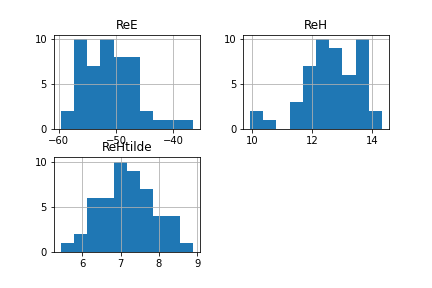

In [63]:
%matplotlib inline
results.hist()
plt.show()

In [70]:
print("95% Lower Bound:")
print(results.mean() - 2*results.std())
print("\n95% Upper Bound:")
print(results.mean() + 2*results.std())
print("\nTrue:")
print(df.loc[0, ['ReH', 'ReE', 'ReHtilde']])

95% Lower Bound:
ReH         10.759851
ReE        -60.593245
ReHtilde     5.747379
dtype: float64

95% Upper Bound:
ReH         14.489986
ReE        -41.243545
ReHtilde     8.604668
dtype: float64

True:
ReH         13.05540
ReE        -53.05540
ReHtilde     7.25302
Name: 0, dtype: float64


# Add Preceding Dense Layer

To demonstrate global fit

In [15]:
data = DvcsData(df)
set0 = data.getSet(0)

## Model

### Define functional layer

In [118]:
class TotalUUXS(tf.keras.layers.Layer):
    def __init__(self):
        super(TotalUUXS, self).__init__(dtype='float64')
        self.F = BHDVCS()
    def call(self, inputs):
        return self.F.TotalUUXS(inputs[:, :8], inputs[:, 8], inputs[:, 9], inputs[:, 10])

### Define model

In [234]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = TotalUUXS()(totalUUXSInputs)

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

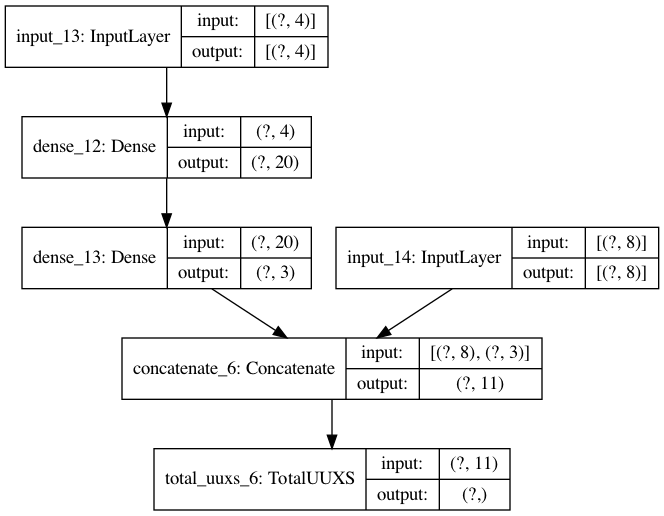

In [235]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [236]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(1),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [237]:
globalModel.summary()

Model: "GlobalModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 20)           100         input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 3)            63          dense_12[0][0]                   
________________________________________________________________________________________

In [247]:
def cffs_from_globalModel(model):
    subModel = tf.keras.backend.function(model.layers[0].input, model.layers[3].output)
    return subModel(np.asarray(set0.Kinematics)[None, 0])[0]

In [254]:
numSamples = 20
results = pd.DataFrame({
  "ReH": np.zeros(numSamples),
  "ReE": np.zeros(numSamples),
  "ReHtilde": np.zeros(numSamples)
})

In [265]:
for i in tqdm(range(numSamples)):
    setI = data.getSet(0)
    
    chkpt_path = 'networks/sample-' + str(i) + '.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=chkpt_path,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
        
    globalModel.compile(
        optimizer = tf.keras.optimizers.Adam(1),
        loss = tf.keras.losses.MeanSquaredError(),
    )
    
    globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(),
                epochs=2000, verbose=0,
                callbacks=[model_checkpoint_callback])
    
    globalModel.load_weights(chkpt_path)

    cffs = cffs_from_globalModel(globalModel)
    
    for num, cff in enumerate(['ReH', 'ReE', 'ReHtilde']):
        results.loc[i, cff] = cffs[num]

100%|██████████| 20/20 [06:58<00:00, 20.93s/it]


In [266]:
results

,ReH,ReE,ReHtilde
0,14.034393,-59.585411,7.784769
1,14.176863,-56.442562,6.728830
2,14.158726,-60.749958,8.066148
3,14.660316,-63.306622,6.730144
4,15.628878,-65.046349,7.357785
5,15.036820,-65.680298,7.368266
6,12.993145,-59.284203,7.366944
7,13.297242,-57.952564,7.038604
8,13.768682,-59.008068,8.646922
9,14.514191,-59.038734,7.667815


In [268]:
print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[0, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))

             Fitted     Error      True
ReH       13.710613  0.939287  13.05540
ReE      -57.384955  4.731970 -53.05540
ReHTilde   7.147711  0.783813   7.25302


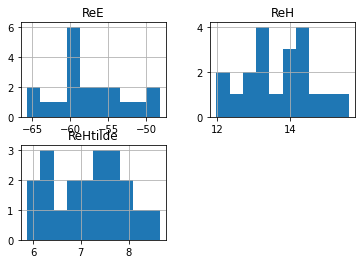

In [269]:
results.hist()
plt.show()

## For all layers

In [276]:
numSamples = 20

for i in tqdm(range(max(df['#Set'])+1)):
    setI = data.getSet(i)
    
    results = pd.DataFrame({
      "ReH": np.zeros(numSamples),
      "ReE": np.zeros(numSamples),
      "ReHtilde": np.zeros(numSamples)
    })
    
    for sample in range(numSamples):

        chkpt_path = 'networks/sample-' + str(sample) + '.hdf5'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=chkpt_path,
            save_weights_only=True,
            monitor='loss',
            mode='min',
            save_best_only=True)


        globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(),
                    epochs=2000, verbose=0,
                    callbacks=[model_checkpoint_callback])

        globalModel.load_weights(chkpt_path)

        cffs = cffs_from_globalModel(globalModel)

        for num, cff in enumerate(['ReH', 'ReE', 'ReHtilde']):
            results.loc[sample, cff] = cffs[num]
        
    print("\nSet " + str(i) + ":")
    print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[36*i, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))

  7%|▋         | 1/15 [05:40<1:19:28, 340.63s/it]

/nSet 0:
             Fitted     Error      True
ReH       14.112047  0.839516  13.05540
ReE      -58.437803  4.429472 -53.05540
ReHTilde   6.838609  0.695969   7.25302


 13%|█▎        | 2/15 [11:15<1:13:25, 338.86s/it]

/nSet 1:
             Fitted      Error      True
ReH        9.857827   1.787724  12.55490
ReE      -35.212994  10.331747 -52.55490
ReHTilde   8.698388   1.193308   6.97494


 20%|██        | 3/15 [17:12<1:08:53, 344.42s/it]

/nSet 2:
             Fitted      Error      True
ReH        6.104657   2.262513   7.22424
ReE      -39.823050  11.300533 -47.22420
ReHTilde   4.362656   1.265079   4.01347


 27%|██▋       | 4/15 [23:00<1:03:20, 345.54s/it]

/nSet 3:
             Fitted      Error      True
ReH       16.262868   3.544243   7.65272
ReE      -90.153913  16.549670 -47.65270
ReHTilde   7.094729   2.032860   4.25151


 33%|███▎      | 5/15 [28:50<57:46, 346.68s/it]  

/nSet 4:
             Fitted     Error      True
ReH       12.077860  1.612539  12.55490
ReE      -49.304365  8.065214 -52.55490
ReHTilde   8.059329  0.810763   6.97494


 40%|████      | 6/15 [34:41<52:13, 348.14s/it]

/nSet 5:
             Fitted      Error      True
ReH        6.392732   2.396263   7.22424
ReE      -42.352917  13.222071 -47.22420
ReHTilde   4.201439   1.360092   4.01347


 47%|████▋     | 7/15 [40:32<46:31, 348.94s/it]

/nSet 6:
             Fitted      Error      True
ReH        9.178450   2.506945  11.74110
ReE      -36.974342  13.620177 -51.74110
ReHTilde   7.511688   1.848255   6.52283


 53%|█████▎    | 8/15 [46:22<40:44, 349.26s/it]

/nSet 7:
             Fitted     Error      True
ReH       14.763195  1.707514   7.65272
ReE      -82.351760  9.056202 -47.65270
ReHTilde   8.632302  2.019256   4.25151


 60%|██████    | 9/15 [52:40<35:46, 357.78s/it]

/nSet 8:
             Fitted     Error      True
ReH       12.617230  0.884607  12.55490
ReE      -51.805277  3.472707 -52.55490
ReHTilde   7.707290  0.998357   6.97494


 67%|██████▋   | 10/15 [58:51<30:09, 361.94s/it]

/nSet 9:
             Fitted     Error      True
ReH        8.479805  1.364516   6.99014
ReE      -55.217646  8.257389 -46.99010
ReHTilde   3.456119  0.693445   3.88341


 73%|███████▎  | 11/15 [1:04:50<24:03, 360.91s/it]

/nSet 10:
             Fitted      Error      True
ReH        6.638444   1.941864   7.22424
ReE      -44.125384  10.323857 -47.22420
ReHTilde   4.211899   1.130377   4.01347


 80%|████████  | 12/15 [1:10:53<18:04, 361.45s/it]

/nSet 11:
             Fitted     Error      True
ReH        9.575435  1.734397  11.74110
ReE      -40.878047  9.090715 -51.74110
ReHTilde   7.189890  1.432066   6.52283


 87%|████████▋ | 13/15 [1:16:45<11:57, 358.74s/it]

/nSet 12:
             Fitted     Error      True
ReH        7.913685  1.240425   6.99014
ReE      -53.158244  7.355335 -46.99010
ReHTilde   3.335798  1.266490   3.88341


 93%|█████████▎| 14/15 [1:22:38<05:56, 356.93s/it]

/nSet 13:
             Fitted     Error      True
ReH        7.270663  1.470821   7.22424
ReE      -46.851896  8.073560 -47.22420
ReHTilde   4.341389  1.327850   4.01347


100%|██████████| 15/15 [1:28:10<00:00, 352.73s/it]

/nSet 14:
             Fitted     Error      True
ReH       11.951709  1.252804  11.74110
ReE      -51.748105  6.959838 -51.74110
ReHTilde   6.524182  1.185902   6.52283
